In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [37]:
# load the dataset 
file_path = './heart.csv'
data = pd.read_csv(file_path)
data


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### Data Preprocessing ###

In [38]:
# Separate features and target variable
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

In [39]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')  # Drop first to avoid dummy variable trap

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit the preprocessor to get the correct feature names after transformation
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

# Get feature names after transformation
encoded_feature_names = list(preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols)) + \
                        list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))




In [40]:
# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


# Define the model
model = RandomForestClassifier(random_state=42)

In [41]:
# Create a pipeline that applies the model (preprocessing is already done)
pipeline = Pipeline(steps=[('classifier', model)])


# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

In [42]:
# Hyperparameter Tuning using Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [43]:
# Best parameters found by Grid Search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [44]:
# Assess model performance
y_pred = grid_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion Matrix:
 [[65 12]
 [13 94]]
Accuracy Score:  0.8641304347826086


### LIME for Explainability ###

In [48]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# LIME for explainability
# Fit the final model with best parameters
final_model = grid_search.best_estimator_

# LIME explainer
explainer = LimeTabularExplainer(training_data=X_train,
                                 feature_names=encoded_feature_names,
                                 class_names=['No Disease', 'Disease'],
                                 mode='classification',
                                 discretize_continuous=True)

# Explain a prediction
sample_idx = 0  # Index of the sample to explain
exp = explainer.explain_instance(X_test[sample_idx], 
                                 final_model.predict_proba, 
                                 num_features=10)

# Display explanation
exp.show_in_notebook(show_table=True, show_all=False)


*Summary*

The LIME explanation shows that: the features "ST_Slope_Up," "ST_Slope_Flat," "ExerciseAngina_Y," "ChestPainType_ATA," "MaxHR," "Oldpeak," and "FastingBS" strongly support the model's prediction of "No Disease."

Features like "ChestPainType_NAP," "ChestPainType_TA," and "Age" have a negative contribution towards "Disease," but their impact is smaller compared to the positive contributions towards "No Disease."

### Surrogate Model (Decision Tree) ###

Random Forest Model Performance on Test Data:
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

Confusion Matrix:
 [[66 11]
 [12 95]]
Accuracy Score:  0.875

Surrogate Decision Tree Model Performance on Test Data:
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85        78
           1       0.90      0.89      0.89       106

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

Confusion Matrix:
 [[67 11]
 [12 94]]
Accuracy Score:  0.875


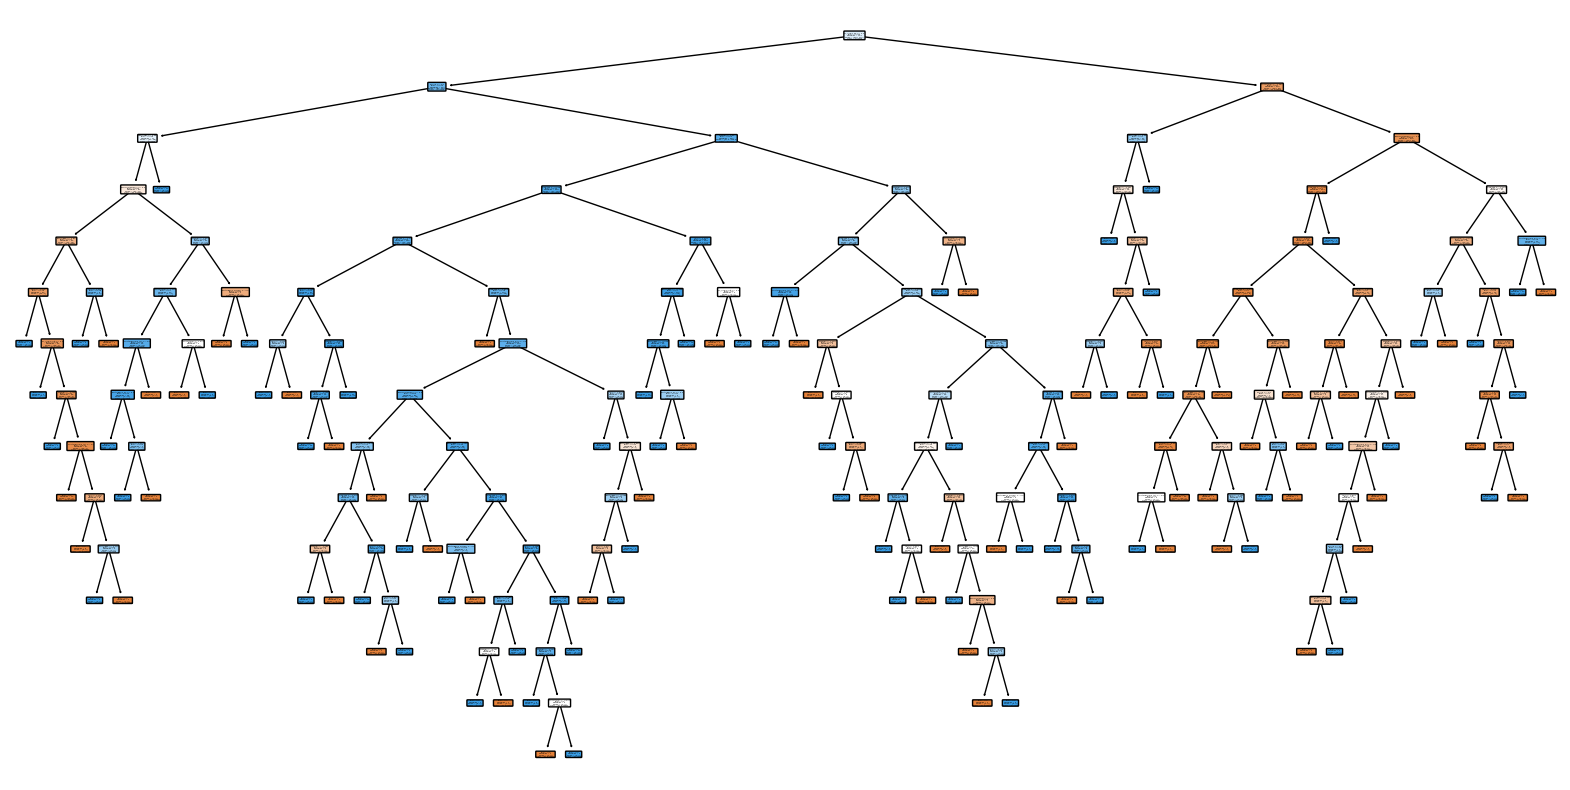

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Load the dataset
file_path = './heart.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
# Separate features and target variable
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=(['int64', 'float64'])).columns

# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')  # Drop first to avoid dummy variable trap

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a pipeline that preprocesses the data then applies the Random Forest model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf_model)])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Use the trained Random Forest model to predict the training data
rf_predictions_train = rf_pipeline.predict(X_train)

# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model on the original features with Random Forest predictions as target
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', dt_model)])

dt_pipeline.fit(X_train, rf_predictions_train)

# Evaluate the Decision Tree model
rf_predictions_test = rf_pipeline.predict(X_test)
dt_predictions_test = dt_pipeline.predict(X_test)

print("Random Forest Model Performance on Test Data:")
print("Classification Report:\n", classification_report(y_test, rf_predictions_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions_test))
print("Accuracy Score: ", accuracy_score(y_test, rf_predictions_test))

print("\nSurrogate Decision Tree Model Performance on Test Data:")
print("Classification Report:\n", classification_report(rf_predictions_test, dt_predictions_test))
print("Confusion Matrix:\n", confusion_matrix(rf_predictions_test, dt_predictions_test))
print("Accuracy Score: ", accuracy_score(rf_predictions_test, dt_predictions_test))

# Visualize the Decision Tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=encoded_feature_names, class_names=['No Disease', 'Disease'], filled=True, rounded=True)
plt.show()
